---
title: State Estimation - Strong Constrained 4DVar
subject: Modern 4DVar
subtitle: How to estimate the state using a dynamical ODE
short_title: State Est. - Strong
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: data-assimilation, open-science
abbreviations:
    GP: Gaussian Process
---

In [1]:
import os, sys

jaxsw_path = "/Users/eman/code_projects/jaxsw"
sys.path.append(jaxsw_path)

In [2]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx
import equinox as eqx
import xarray as xr
import functools as ft

from jaxsw import L63State, Lorenz63, rhs_lorenz_63

jax.config.update("jax_enable_x64", True)

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 63

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $(\sigma,\rho,\beta)$ are hyperparameters.

## Simulation

In [3]:
ds_sol = xr.open_dataset("./data/sim_l63.nc")
ds_sol

<xarray.Dataset>
Dimensions:              (time: 200, component: 3, realization: 1000)
Coordinates:
  * time                 (time) float32 0.0 0.01 0.02 0.03 ... 1.97 1.98 1.99
  * component            (component) object 'x' 'y' 'z'
Dimensions without coordinates: realization
Data variables:
    simulation           (component, realization, time) float32 ...
    observations         (component, realization, time) float32 ...
    observations_noise   (component, realization, time) float64 ...
    observations_interp  (component, realization, time) float64 ...

## Inverse Problem

In [4]:
realization = 100

ds_trajectory = ds_sol.sel(realization=realization)
ds_trajectory

<xarray.Dataset>
Dimensions:              (time: 200, component: 3)
Coordinates:
  * time                 (time) float32 0.0 0.01 0.02 0.03 ... 1.97 1.98 1.99
  * component            (component) object 'x' 'y' 'z'
Data variables:
    simulation           (component, time) float32 ...
    observations         (component, time) float32 ...
    observations_noise   (component, time) float64 ...
    observations_interp  (component, time) float64 ...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


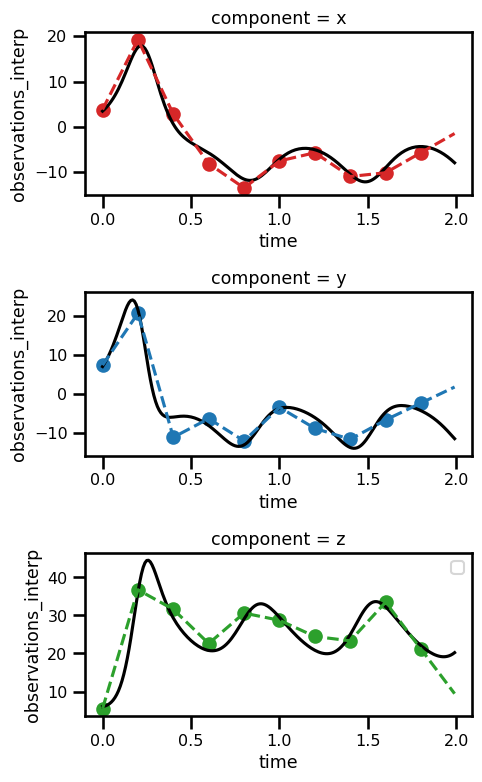

In [5]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))


ds_trajectory.simulation.sel(component="x").plot(ax=ax[0], color="black")
ds_trajectory.simulation.sel(component="y").plot(ax=ax[1], color="black")
ds_trajectory.simulation.sel(component="z").plot(ax=ax[2], color="black")

ds_trajectory.observations_noise.sel(component="x").plot.scatter(
    ax=ax[0], color="tab:red"
)
ds_trajectory.observations_noise.sel(component="y").plot.scatter(
    ax=ax[1], color="tab:blue"
)
ds_trajectory.observations_noise.sel(component="z").plot.scatter(
    ax=ax[2], color="tab:green"
)

ds_trajectory.observations_interp.sel(component="x").plot(
    ax=ax[0], color="tab:red", linestyle="--"
)
ds_trajectory.observations_interp.sel(component="y").plot(
    ax=ax[1], color="tab:blue", linestyle="--"
)
ds_trajectory.observations_interp.sel(component="z").plot(
    ax=ax[2], color="tab:green", linestyle="--"
)

# ax.set_xlabel("Time")
# ax.set_ylabel("Values")
# ax.set_title(f"Trajectory")


plt.legend()
plt.tight_layout()
plt.show()

## Data

For this problem we need the following variables

**True State**: $\boldsymbol{u}$

**Time Steps**: $\boldsymbol{\Tau}$

**Observations**: $\boldsymbol{y}$

**Initial State**: $\boldsymbol{u}^{(k)}$

**Mask**: $\boldsymbol{m}$

In [6]:
# Ground Truth
x_state = jnp.asarray(ds_trajectory.simulation.values).T.astype(jnp.float64)
ts_state = jnp.asarray(ds_trajectory.time.values).astype(jnp.float64)
# Observations
y_gt = jnp.asarray(ds_trajectory.observations_noise.values).T.astype(jnp.float64)
# Mask
y_mask = 1.0 - (
    jnp.isnan(jnp.asarray(ds_trajectory.observations_noise.values))
    .astype(jnp.float32)
    .T.astype(jnp.float64)
)
# initialization
x_init = jnp.asarray(ds_trajectory.observations_interp.values).T.astype(jnp.float64)

x_state.shape, y_gt.shape, y_mask.shape, x_init.shape

((200, 3), (200, 3), (200, 3), (200, 3))

## Dynamical Prior

Here, we define our dynamical prior which we plug into this loss function.

$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
||\boldsymbol{u} - \boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta})||_2^2
$$

Our dynamical prior in this case is defined by:

$$
\boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta}) \coloneqq
\boldsymbol{u}(t_1) =
\boldsymbol{u}(t_0) + \int_{t_0}^{t_1}
\boldsymbol{F}\left( \boldsymbol{u}(t),\tau;\boldsymbol{\theta}\right)d\tau 
$$



**Strong Constrained**

The strong-constrained version works by applying the solver directly through the entire trajectory from start to finish.
We are sure to output the state during moments of the trajectory to ensure that we can check to ensure that we can check out how well they match the observations.
So, the function will look something like:

$$
\left[ \boldsymbol{u}_T, \boldsymbol{u}_{T-\Delta t}, \ldots, \boldsymbol{u}_{\Delta t}, \boldsymbol{u}_0\right] = 
\text{ODESolve}\left(\boldsymbol{F}, \boldsymbol{u}_0, T, \Delta t, \boldsymbol{\theta}, \right)
$$

whereby we get a matrix, $\mathbf{U}\in\mathbb{R}^{D_T\times D_u}$, which contains all of the state vectors for every time step of interest.
So our $\boldsymbol{\phi}$ operator will be

$$
\mathbf{U} = \boldsymbol{\phi}(\boldsymbol{u},t;\boldsymbol{\theta})
$$

and our cost function will be

$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
\sum_{t=0}^T
||\boldsymbol{u}_t - \boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta})_t||_2^2
$$

In [7]:
from mfourdvar._src.priors.dynamical import DynIncrements, DynTrajectory
from jaxsw import L63State, L63Params

In [8]:
import typing as tp
from jaxtyping import Array, PyTree

class L63Params(eqx.Module):
    sigma: Array = eqx.static_field()
    rho: Array = eqx.static_field()
    beta: Array = eqx.static_field()
    
    def __init__(self, sigma: float=10., rho: float=28., beta: float=2.667):
        self.sigma = jnp.asarray(sigma, dtype=jnp.float64)
        self.rho = jnp.asarray(rho, dtype=jnp.float64)
        self.beta = jnp.asarray(beta, dtype=jnp.float64)

class L63Model(eqx.Module):
    model: PyTree

    def init_state(self, x: PyTree) -> PyTree:
        state = L63State(
            x=jnp.atleast_1d(x[..., 0]), 
            y=jnp.atleast_1d(x[..., 1]), 
            z=jnp.atleast_1d(x[..., 2])
        )
        return state
    
    def __call__(self, t, state, args):
        return self.model.equation_of_motion(t, state, args)

In [9]:
x_init.shape

(200, 3)

In [10]:
# init dynamical system
l63_dyn_model = Lorenz63()

# initialize prior model
prior_model = L63Model(model=l63_dyn_model)


# initialize state
state_init = prior_model.init_state(x_init[0])

# initialize params
params = L63Params(sigma=10., rho=28., beta=2.667)


# output state
state_out = prior_model(0, state_init, params)

# check input and output are the same
assert state_init.x.shape == state_out.x.shape
assert state_init.y.shape == state_out.y.shape
assert state_init.z.shape == state_out.z.shape

In [11]:
x_init[0].dtype, ts_state[1:].dtype

(dtype('float64'), dtype('float64'))

In [12]:
# initialize dynamical prior
prior = DynTrajectory(model=prior_model, params=params)

In [13]:
# forward for prior
out = prior(x=x_init[0] + 5., ts=ts_state[1:])
out.x.shape, out.y.shape, out.z.shape, ts_state.shape

((199, 1), (199, 1), (199, 1), (200,))

## Loss Function

We already have access to the loss function via this convenient prior class.
It automatically implements a simple dynamical loss in terms of MSE.

In [14]:
loss = prior.loss(x_init, ts_state, )
loss

Array(6825.24488202, dtype=float64)

## Gradient Function

Now, we need to take the derivatives wrt the state.
The prior model, the params and the time steps are all going to state constant s

In [16]:
prior = DynTrajectory(model=prior_model)

@ft.partial(jax.value_and_grad)
def loss_function_state(x_init, params):
    return prior.loss(x_init, ts_state, params=params)

loss, grads = loss_function_state(x_init, params)
print(grads.shape)


@eqx.filter_value_and_grad
def loss_function_state(x_init, params):
    return prior.loss(x_init, ts_state, params=params)

loss, grads = loss_function_state(x_init, params)
print(grads.shape)
loss

(200, 3)
(200, 3)


Array(6825.24488202, dtype=float64)

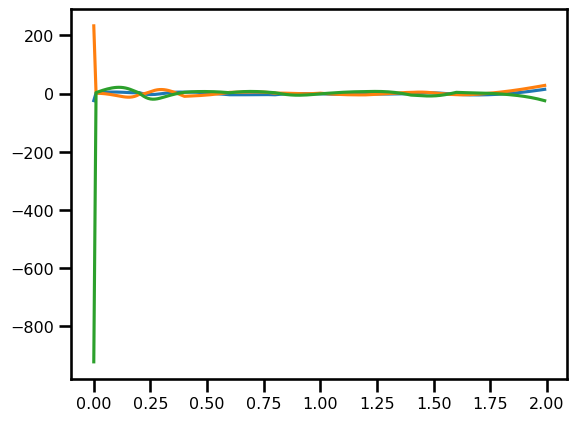

In [17]:
fig, ax = plt.subplots()

ax.plot(ts_state, grads[..., 0].squeeze(), linestyle="-", color="tab:blue")
ax.plot(ts_state, grads[..., 1].squeeze(), linestyle="-", color="tab:orange")
ax.plot(ts_state, grads[..., 2].squeeze(), linestyle="-", color="tab:green")

### Parameter Gradients

In [19]:
@ft.partial(jax.value_and_grad)
def loss_function_params(params, x_init):
    return prior.loss(x_init, ts_state, params=params)

loss, grads = loss_function_params(params, x_init)
print(grads)


@eqx.filter_value_and_grad
def loss_function_params(params, x_init):
    
    return prior.loss(x_init, ts_state, params=params)

loss, grads = loss_function_params(params, x_init)
print(grads)
loss

L63Params(sigma=f64[], rho=f64[], beta=f64[])
L63Params(sigma=f64[], rho=f64[], beta=f64[])


Array(6825.24488202, dtype=float64)

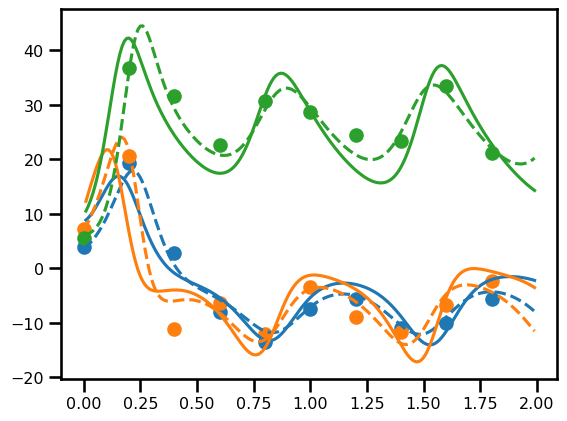

In [20]:
fig, ax = plt.subplots()

ax.plot(ts_state[1:], out.array[..., 0].squeeze(), linestyle="-", color="tab:blue")
ax.plot(ts_state, x_state[..., 0].squeeze(), linestyle="--", color="tab:blue")
ax.scatter(ts_state, y_gt[..., 0], color="tab:blue")
ax.plot(ts_state[1:], out.array[..., 1].squeeze(), linestyle="-", color="tab:orange")
ax.plot(ts_state, x_state[..., 1].squeeze(), linestyle="--", color="tab:orange")
ax.scatter(ts_state, y_gt[..., 1], color="tab:orange")
ax.plot(ts_state[1:], out.array[..., 2].squeeze(), linestyle="-", color="tab:green")
ax.plot(ts_state, x_state[..., 2].squeeze(), linestyle="--", color="tab:green")
ax.scatter(ts_state, y_gt[..., 2],  color="tab:green")

### Learning

In this instance, we're going to use a simple gradient descent scheme.

$$
\boldsymbol{u}^{(k+1)} =
\boldsymbol{u}^{(k)} +
\alpha \boldsymbol{\nabla_u}\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta})
$$

where $\alpha$ is the learning rate and $\boldsymbol{\nabla_u}$ is the gradient operator wrt the state, $\boldsymbol{u}$.
We have an optimality condition of the gradient of the variational cost.

$$
\boldsymbol{F_g}(\boldsymbol{u};\boldsymbol{\theta}) =
\boldsymbol{\nabla_u}\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta})
$$

Because we are doing gradient *descent*, we will use a negative learning rate of $\alpha=-0.1$.

For this first part, we're simply going to use the variational cost as the dynamical prior.

$$
\begin{aligned}
\boldsymbol{J}(\boldsymbol{u};\boldsymbol{\theta}) &=
\boldsymbol{R}(\boldsymbol{u};\boldsymbol{\theta}) \\
&=
\frac{\lambda}{2}
\sum_{t=0}^T
||\boldsymbol{u}_t - \boldsymbol{\phi}(\boldsymbol{u}_t;\boldsymbol{\theta})||_2^2
\end{aligned}
$$

## Observation Operator

$$
\boldsymbol{L}(\boldsymbol{u};\boldsymbol{\theta}) = \lambda_{obs}|| \boldsymbol{y} - \boldsymbol{H}(\boldsymbol{u};\boldsymbol{\theta})||_2^2
$$


We can use a simpler loss function which is just a masking operator.

$$
\boldsymbol{L}(\boldsymbol{u};\boldsymbol{\theta}) = \lambda_{obs}|| \boldsymbol{y} - \boldsymbol{u}||_{\Omega_{obs}}^2
$$

where $\Omega_{obs}$ is the domain of the observation.

In [21]:
from mfourdvar._src.operators.base import ObsOperator

obs_operator = ObsOperator()

obs_operator.loss(x_init, y_gt, y_mask)

Array(0., dtype=float64)

## Variational Cost

In [22]:
from mfourdvar._src.varcost.dynamical import StrongVarCost

In [23]:
# init dynamical system
l63_dyn_model = Lorenz63()

# initialize prior model
prior_model = L63Model(model=l63_dyn_model)
# initialize params
params = L63Params(sigma=10., rho=28., beta=2.667)
# initialize dynamical prior
prior = DynTrajectory(model=prior_model, params=params)

# initialize observation operator
obs_operator = ObsOperator()

# initialize variational cost function
prior_weight = 1.0
obs_op_weight = 0.1
background_weight = 0.1
varcost_fn = StrongVarCost(
    prior=prior, 
    obs_op=obs_operator, 
    prior_weight=prior_weight, 
    obs_op_weight=obs_op_weight, 
    background_weight=background_weight
)

loss_init, losses_init = varcost_fn.loss(x=x_init[0], ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)
loss_true, losses_true = varcost_fn.loss(x=x_state[0], ts=ts_state, y=y_gt,  mask=y_mask, return_loss=True)

In [24]:
loss_init, losses_init

(Array(13.13013833, dtype=float64),
 {'var_loss': Array(13.13013833, dtype=float64),
  'obs': Array(116.67463353, dtype=float64),
  'bg': Array(14.62674975, dtype=float64)})

In [25]:
print("True State vs True State")
print(losses_true)
print("Init X vs Init State") 
print(losses_init)

True State vs True State
{'var_loss': Array(12.20563867, dtype=float64), 'obs': Array(103.49842271, dtype=float64), 'bg': Array(18.55796399, dtype=float64)}
Init X vs Init State
{'var_loss': Array(13.13013833, dtype=float64), 'obs': Array(116.67463353, dtype=float64), 'bg': Array(14.62674975, dtype=float64)}


### Learning

In [28]:


@ft.partial(jax.value_and_grad, has_aux=True)
def loss_function_state(x_init):    
    return varcost_fn.loss(x=x_init, ts=ts_state, y=y_gt,  mask=y_mask, return_loss=True)

(loss, _), grads = loss_function_state(x_init[0])
print(grads.shape)

@eqx.filter_value_and_grad(has_aux=True)
def loss_function_state(x_init):    
    return varcost_fn.loss(x=x_init, ts=ts_state, y=y_gt,  mask=y_mask, return_loss=True)

(loss, _), grads = loss_function_state(x_init[0])
print(grads.shape)
loss

(3,)
(3,)


Array(13.13013833, dtype=float64)

In [29]:
(loss, losses), grads = loss_function_state(x_init[0])
loss

Array(13.13013833, dtype=float64)

In [30]:
import jaxopt

@ft.partial(jax.value_and_grad, has_aux=True)
def objective_fn(x_init, oparams):
    return varcost_fn.loss(x=x_init, ts=ts_state, y=y_gt,  mask=y_mask, return_loss=True, params=oparams)

objective_fn(x_init[0], params)

((Array(13.13013833, dtype=float64),
  {'bg': Array(14.62674975, dtype=float64),
   'obs': Array(116.67463353, dtype=float64),
   'var_loss': Array(13.13013833, dtype=float64)}),
 Array([ 1.6533432 ,  3.49085841, -1.43647224], dtype=float64))

In [47]:
free_params, static_params = eqx.partition(varcost_fn, eqx.is_array)

def objective_fn(x_init, oparams):
    # combine them
    varcost_fn = eqx.combine(oparams, static_params)
    return varcost_fn.loss(x=x_init, ts=ts_state, y=y_gt,  mask=y_mask, return_loss=True, params=oparams)


In [71]:
num_iterations = 100

def minimization_fn(oparams, x_init):
    
    solver = jaxopt.GradientDescent(fun=objective_fn, maxiter=num_iterations, has_aux=True, implicit_diff=False)
    
    return solver.run(init_params=x_init, oparams=oparams).params

@ft.partial(jax.grad)
def validation_loss(oparams, x_init):
    sol = minimization_fn(oparams, x_init)
    return jnp.mean((sol - x_init)**2)

sol = minimization_fn(free_params, x_init[0])
print(sol)

%memit validation_loss(free_params, x_init[0])
# %timeit validation_loss(free_params, x_init[0])
# grads.prior.params.beta


# init solver



[4.55831272 5.4645038  5.32600284]
peak memory: 1197.08 MiB, increment: 144.08 MiB


In [72]:
%timeit
num_iterations = 100

def minimization_fn(oparams, x_init):
    
    solver = jaxopt.GradientDescent(fun=objective_fn, maxiter=num_iterations, has_aux=True, implicit_diff=True)
    
    return solver.run(init_params=x_init, oparams=oparams).params

@ft.partial(jax.grad)
def validation_loss(oparams, x_init):
    sol = minimization_fn(oparams, x_init)
    return jnp.mean((sol - x_init)**2)

sol = minimization_fn(free_params, x_init[0])
print(sol)

# %timeit validation_loss(free_params, x_init[0])
%memit validation_loss(free_params, x_init[0])



# init solver

[4.55831272 5.4645038  5.32600284]
peak memory: 1289.06 MiB, increment: 0.00 MiB


In [70]:
%load_ext memory_profiler


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 1017.56 MiB, increment: 412.55 MiB


In [60]:
grads.prior.params.beta

Array(2.667, dtype=float64)

In [58]:
jax.jacfwd(minimization_fn, argnums=0)(free_params, x_init[0])

ValueError: at least one array or dtype is required

In [64]:
@eqx.fil
def minimization_fn(oparams, x_init):
    
    solver = jaxopt.GradientDescent(fun=objective_fn, maxiter=num_iterations, has_aux=True)
    
    return solver.run(init_params=x0, oparams=oparams).params

TypeError: minimization_fn() missing 2 required positional arguments: 'oparams' and 'x_init'

In [60]:
sol = minimization_fn(params, x0)

In [52]:
from tqdm.autonotebook import trange

losses = dict(prior=[], obs=[], bg=[], var_loss=[])
num_iterations = 100
learning_rate = - 0.2
x0 = x_init.copy()[0]

# loop through learning
with trange(num_iterations) as pbar:
    for i in pbar:

        # get dynamical loss + gradient
        (_, loss), x_grad = loss_function_state(x0)

        losses["var_loss"].append(loss["var_loss"])
        losses["obs"].append(loss["obs"])
        losses["bg"].append(loss["bg"])

        pbar_msg = f"Var Loss: {loss['var_loss']:.2e} | "
        pbar_msg += f"Obs - {loss['obs']:.2e} | "
        pbar_msg += f"BG - {loss['bg']:.2e}"
        pbar.set_description(pbar_msg)

        # clip gradients (prevent explosion)
        x_grad = jnp.clip(x_grad, a_min=-0.5, a_max=0.5)

        # update solution with gradient
        x0 += learning_rate * x_grad

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
x0, x_init[0], grads

(Array([4.55909722, 5.4635627 , 5.325818  ], dtype=float64),
 Array([3.83415643, 7.27995046, 5.49344943], dtype=float64),
 Array([ 1.6533432 ,  3.49085841, -1.43647224], dtype=float64))

In [32]:
# compute variational cost
loss_init, losses_init = varcost_fn.loss(x=x_init[0], ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)
loss_true, losses_true = varcost_fn.loss(x=x_state[0], ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)
loss_sol_true, losses_sol_true = varcost_fn.loss(x=x0, ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)


In [33]:
print("True State vs True State")
print(losses_true)
print("Init X vs Init State") 
print(losses_init)
print("Sol State vs True State")
print(losses_sol_true)

True State vs True State
{'var_loss': Array(12.20563867, dtype=float64), 'obs': Array(103.49842271, dtype=float64), 'bg': Array(18.55796399, dtype=float64)}
Init X vs Init State
{'var_loss': Array(13.13013833, dtype=float64), 'obs': Array(116.67463353, dtype=float64), 'bg': Array(14.62674975, dtype=float64)}
Sol State vs True State
{'var_loss': Array(10.67219794, dtype=float64), 'obs': Array(105.31606079, dtype=float64), 'bg': Array(1.40591857, dtype=float64)}


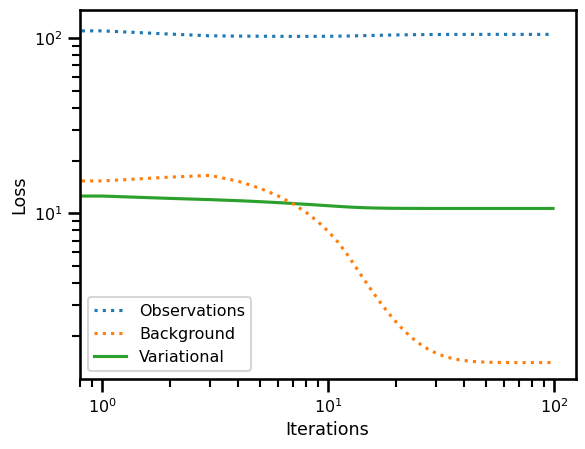

In [34]:
fig, ax = plt.subplots()

ax.plot(losses["obs"], label="Observations", linestyle=":")
ax.plot(losses["bg"], label="Background", linestyle=":")
ax.plot(losses["var_loss"], label="Variational", zorder=0)

ax.set(
    yscale="log",
    xscale="log",
    xlabel="Iterations", 
    ylabel="Loss"
)

plt.legend()
plt.show()

In [35]:
x = prior(x0, ts_state)
x = x.array
x0.shape, x.shape

((3,), (200, 3))

In [36]:
ds_results = xr.Dataset(
    {
        "x": (("time"), x[:, 0].squeeze()),
        "y": (("time"), x[:, 1].squeeze()),
        "z": (("time"), x[:, 2].squeeze()),
    },
    coords={
        "time": (["time"], ts_state.squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_results = ds_results.to_array(dim="component", name="prediction").to_dataset()
ds_results["state"] = (
    (
        "component",
        "time",
    ),
    x_state.T,
)
ds_results["initialization"] = (
    (
        "component",
        "time",
    ),
    x_init.T,
)
ds_results["observation"] = (
    (
        "component",
        "time",
    ),
    y_gt.T,
)
# ds_results.x_state
ds_results

<xarray.Dataset>
Dimensions:         (time: 200, component: 3)
Coordinates:
  * time            (time) float64 0.0 0.01 0.02 0.03 ... 1.96 1.97 1.98 1.99
  * component       (component) object 'x' 'y' 'z'
Data variables:
    prediction      (component, time) float64 4.559 4.693 4.908 ... 20.82 21.23
    state           (component, time) float64 3.473 3.838 4.24 ... 19.88 20.22
    initialization  (component, time) float64 3.834 4.606 5.379 ... 10.05 9.436
    observation     (component, time) float64 3.834 nan nan nan ... nan nan nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


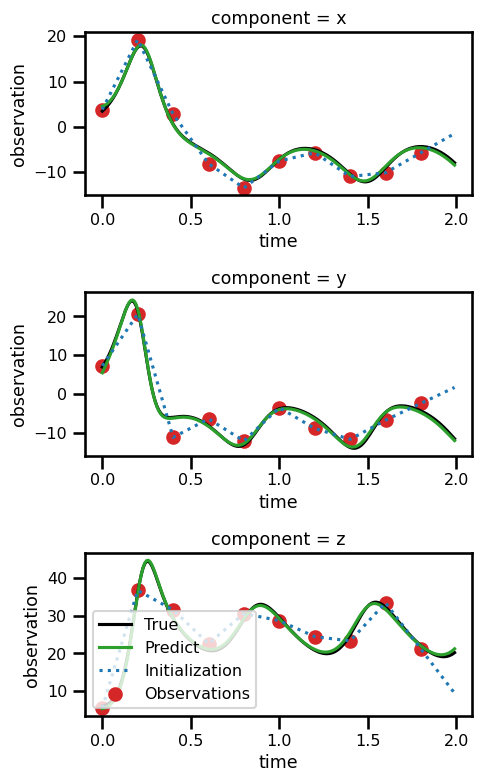

In [37]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for axis in range(3):
    ds_results.state.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="black", label="True"
    )
    ds_results.prediction.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="tab:green", label="Predict"
    )
    ds_results.initialization.isel(component=axis).plot(
        ax=ax[axis], linestyle=":", color="tab:blue", label="Initialization"
    )
    ds_results.observation.isel(component=axis).plot.scatter(
        ax=ax[axis], color="tab:red", label="Observations"
    )
    plt.legend()


# plt.legend()
plt.tight_layout()
plt.show()

## Crazier Initial Condition

In [39]:
from tqdm.autonotebook import trange

losses = dict(prior=[], obs=[], bg=[], var_loss=[])
num_iterations = 100
learning_rate = - 0.2
x0 = x_init.copy()[0] + 5.0

# loop through learning
with trange(num_iterations) as pbar:
    for i in pbar:

        # get dynamical loss + gradient
        (_, loss), x_grad = loss_function_state(x0)

        losses["var_loss"].append(loss["var_loss"])
        losses["obs"].append(loss["obs"])
        losses["bg"].append(loss["bg"])

        pbar_msg = f"Var Loss: {loss['var_loss']:.2e} | "
        pbar_msg += f"Obs - {loss['obs']:.2e} | "
        pbar_msg += f"BG - {loss['bg']:.2e}"
        pbar.set_description(pbar_msg)

        # clip gradients (prevent explosion)
        x_grad = jnp.clip(x_grad, a_min=-0.5, a_max=0.5)

        # update solution with gradient
        x0 += learning_rate * x_grad

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
x_init[0], grads

(Array([3.83415643, 7.27995046, 5.49344943], dtype=float64),
 Array([ 1.6533432 ,  3.49085841, -1.43647224], dtype=float64))

In [42]:
# compute variational cost
loss_init, losses_init = varcost_fn.loss(x=x_init[0] + 5., ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)
loss_true, losses_true = varcost_fn.loss(x=x_state[0], ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)
loss_sol_true, losses_sol_true = varcost_fn.loss(x=x0, ts=ts_state, y=y_gt, mask=y_mask, return_loss=True)


In [43]:
print("True State vs True State")
print(losses_true)
print("Init X vs Init State") 
print(losses_init)
print("Sol State vs True State")
print(losses_sol_true)

True State vs True State
{'var_loss': Array(12.20563867, dtype=float64), 'obs': Array(103.49842271, dtype=float64), 'bg': Array(18.55796399, dtype=float64)}
Init X vs Init State
{'var_loss': Array(72.42176102, dtype=float64), 'obs': Array(709.59086047, dtype=float64), 'bg': Array(14.62674975, dtype=float64)}
Sol State vs True State
{'var_loss': Array(10.67220015, dtype=float64), 'obs': Array(105.30777161, dtype=float64), 'bg': Array(1.41422986, dtype=float64)}


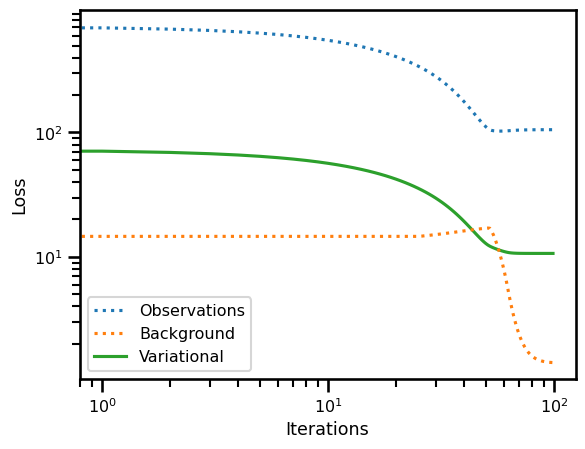

In [44]:
fig, ax = plt.subplots()

ax.plot(losses["obs"], label="Observations", linestyle=":")
ax.plot(losses["bg"], label="Background", linestyle=":")
ax.plot(losses["var_loss"], label="Variational", zorder=0)

ax.set(
    yscale="log",
    xscale="log",
    xlabel="Iterations", 
    ylabel="Loss"
)

plt.legend()
plt.show()

In [45]:
x = prior(x0, ts_state)
x = x.array
x0.shape, x.shape

((3,), (200, 3))

In [46]:
ds_results = xr.Dataset(
    {
        "x": (("time"), x[:, 0].squeeze()),
        "y": (("time"), x[:, 1].squeeze()),
        "z": (("time"), x[:, 2].squeeze()),
    },
    coords={
        "time": (["time"], ts_state.squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_results = ds_results.to_array(dim="component", name="prediction").to_dataset()
ds_results["state"] = (
    (
        "component",
        "time",
    ),
    x_state.T,
)
ds_results["initialization"] = (
    (
        "component",
        "time",
    ),
    x_init.T,
)
ds_results["observation"] = (
    (
        "component",
        "time",
    ),
    y_gt.T,
)
# ds_results.x_state
ds_results

<xarray.Dataset>
Dimensions:         (time: 200, component: 3)
Coordinates:
  * time            (time) float64 0.0 0.01 0.02 0.03 ... 1.96 1.97 1.98 1.99
  * component       (component) object 'x' 'y' 'z'
Data variables:
    prediction      (component, time) float64 4.558 4.692 4.907 ... 20.82 21.23
    state           (component, time) float64 3.473 3.838 4.24 ... 19.88 20.22
    initialization  (component, time) float64 3.834 4.606 5.379 ... 10.05 9.436
    observation     (component, time) float64 3.834 nan nan nan ... nan nan nan

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


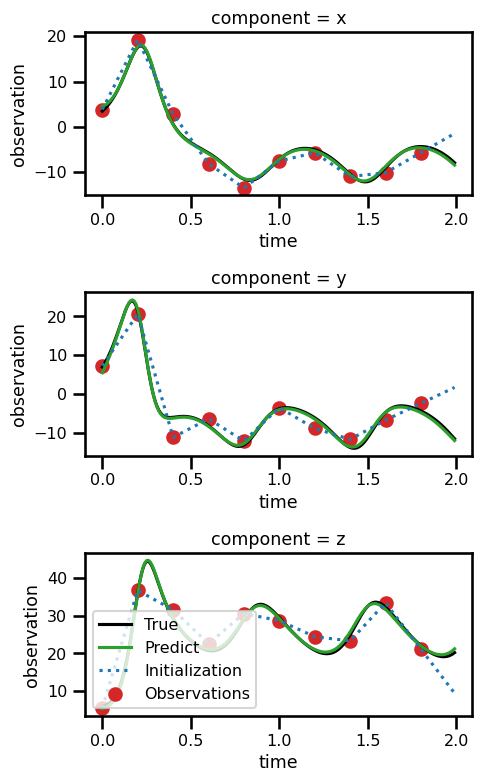

In [47]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for axis in range(3):
    ds_results.state.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="black", label="True"
    )
    ds_results.prediction.isel(component=axis).plot(
        ax=ax[axis], linestyle="-", color="tab:green", label="Predict"
    )
    ds_results.initialization.isel(component=axis).plot(
        ax=ax[axis], linestyle=":", color="tab:blue", label="Initialization"
    )
    ds_results.observation.isel(component=axis).plot.scatter(
        ax=ax[axis], color="tab:red", label="Observations"
    )
    plt.legend()


# plt.legend()
plt.tight_layout()
plt.show()